In [1]:
import operator
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    property_url: str
    is_rent: bool
    is_sell: bool
    blog: str

In [2]:
def sell_or_rent_property(state: State):
    property_url = state["property_url"]
    # complex logic
    if "sell" in property_url:
        is_sell = True
        is_rent = False
    else:
        is_sell = False
        is_rent = True
    return {"is_sell": is_sell, "is_rent": is_rent}

def sell_blog_generator(state: State):
    property_url = state["property_url"]
    blog = f"Generated sell blog based on {property_url}"
    return {"blog": blog}

def rent_blog_generator(state: State):
    property_url = state["property_url"]
    blog = f"Generated rent blog based on {property_url}"
    return {"blog": blog}

In [3]:
def router(state: State):
    if state["is_rent"]:
        return "rent"
    else:
        return "sell"

In [4]:
from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node(sell_or_rent_property)
graph_builder.add_node(sell_blog_generator)
graph_builder.add_node(rent_blog_generator)

graph_builder.add_edge(START, "sell_or_rent_property")

graph_builder.add_conditional_edges(
    "sell_or_rent_property",
    router,
    {"rent": "rent_blog_generator", "sell": "sell_blog_generator"}
)

graph_builder.add_edge("rent_blog_generator", END)
graph_builder.add_edge("sell_blog_generator", END)


graph = graph_builder.compile()

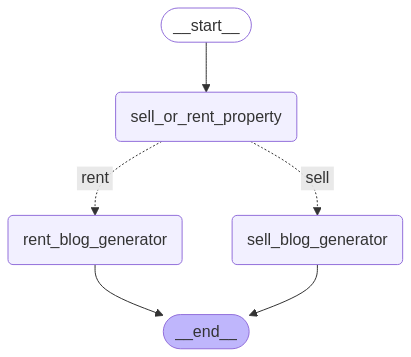

In [5]:
graph

In [7]:
result = graph.invoke({"property_url": "sellyouplace.com"})
result

{'property_url': 'sellyouplace.com',
 'is_rent': False,
 'is_sell': True,
 'blog': 'Generated sell blog based on sellyouplace.com'}

In [8]:
class State(TypedDict):
    property_url: str
    is_rent: bool
    is_sell: bool
    blog: str
    evaluator_comments: str

In [15]:
import random


def sell_or_rent_property(state: State):
    property_url = state["property_url"]
    if "sell" in property_url:
        is_sell = True
        is_rent = False
    else:
        is_sell = False
        is_rent = True
    return {"is_sell": is_sell, "is_rent": is_rent}

def sell_blog_generator(state: State):
    property_url = state["property_url"]
    evaluator_comments = state.get("evaluator_comments", "")
    if evaluator_comments:
        print("re-writing sell blog based on comments")
        blog = f"Re-Generated sell blog based on {property_url} and {evaluator_comments}"
    else:
        print("writing sell blog based on comments")
        blog = f"Generated sell blog based on {property_url}"
    return {"blog": blog}

def rent_blog_generator(state: State):
    property_url = state["property_url"]
    evaluator_comments = state.get("evaluator_comments", "")
    if evaluator_comments:
        print("re-writing rent blog based on comments")
        blog = f"Re-Generated rent blog based on {property_url} and {evaluator_comments}"
    else:
        print("writing rent blog based on comments")
        blog = f"Generated rent blog based on {property_url}"
    return {"blog": blog}

def blog_evaluator(state: State):
    blog = state["blog"]
    
    # complex logic
    
    evaluator_comments = "Why is it so messy, fix everything." if random.randint(0, 1) else ""
    print(f"Evaluator results: {evaluator_comments}")
    return {"evaluator_comments": evaluator_comments}
    

In [16]:
def router(state: State):
    if state["is_rent"]:
        return "rent"
    else:
        return "sell"

def evaluator_router(state: State):
    if state["evaluator_comments"]:
        if state["is_rent"]:
            return "rent"
        else:
            return "sell"
    else:
        return "end"

In [17]:
from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node(sell_or_rent_property)
graph_builder.add_node(sell_blog_generator)
graph_builder.add_node(rent_blog_generator)
graph_builder.add_node(blog_evaluator)

graph_builder.add_edge(START, "sell_or_rent_property")

graph_builder.add_conditional_edges(
    "sell_or_rent_property",
    router,
    {"rent": "rent_blog_generator", "sell": "sell_blog_generator"}
)

graph_builder.add_edge("rent_blog_generator", "blog_evaluator")
graph_builder.add_edge("sell_blog_generator", "blog_evaluator")

graph_builder.add_conditional_edges(
    "blog_evaluator",
    evaluator_router,
    {"rent": "rent_blog_generator", "sell": "sell_blog_generator", "end": END}
)

graph = graph_builder.compile()

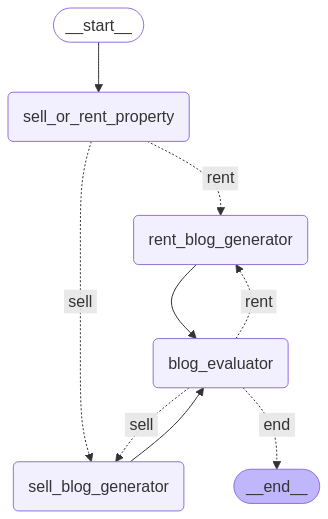

In [18]:
graph

In [20]:
result = graph.invoke({"property_url": "rentyouplace.com"})
result

writing rent blog based on comments
Evaluator results: Why is it so messy, fix everything.
re-writing rent blog based on comments
Evaluator results: 


{'property_url': 'rentyouplace.com',
 'is_rent': True,
 'is_sell': False,
 'blog': 'Re-Generated rent blog based on rentyouplace.com and Why is it so messy, fix everything.',
 'evaluator_comments': ''}